In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import pytorch_lightning as pl
import torch
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

pl.seed_everything(1)
np.random.seed(1)

Global seed set to 1


Here, we seek to find a hidden PDE in force measurements from Coulomb electrostatics. The true relationship between observables $\mathbf{F},\phi$ is

$$ \mathbf{F}(\mathbf{x}) = \frac{1}{2\pi \epsilon_0} \int d^2 \mathbf{r} \, \rho(\mathbf{r}) \rho(\mathbf{x} - \mathbf{r}) \log |x-r| \cdot (\mathbf{x} - \mathbf{r})$$ 

This relationship is nonlinear in $\rho$ and cannot be recast in terms of a linear PDE between $\mathbf{F}$ and $\mathbf{\rho}$. However, there **is** an underlying PDE between the charge density $\rho$ and an unobserved potential field $\phi$. Our procedure can uncover this underlying relationship, as well as a method for computing $\mathbf{F}$ from $\phi$

# Generate data

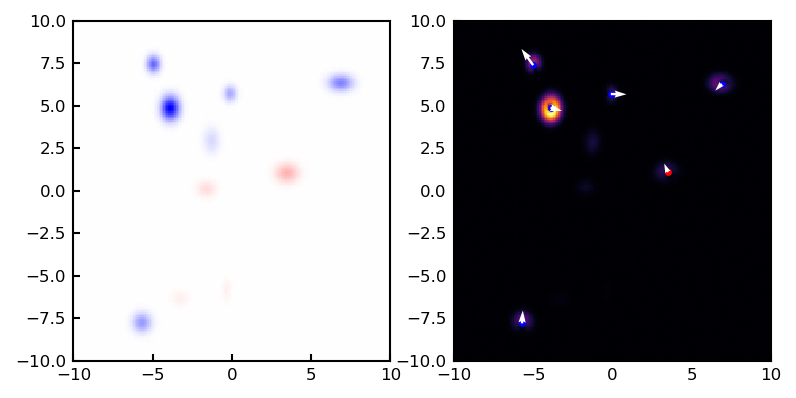

In [137]:
import torch.fft as fft

mtwopii = -2.0j * np.pi
import matplotlib

lw = 1
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['font.size'] = 8
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'lower'
from skimage.transform import downscale_local_mean
from scipy.ndimage import maximum_filter1d
from scipy.ndimage import label
from skimage import measure
from scipy.interpolate import RectBivariateSpline

def prominent_peaks(image, min_dist=2, threshold=None):
    img = image.copy()
    rows, cols = img.shape
    if threshold is None:
        threshold = 0.5 * np.max(img)
    yc_size = 2 * min_dist + 1
    xc_size = 2 * min_dist + 1
    img_max = maximum_filter1d(img, size=yc_size, axis=0, mode='constant', cval=0)
    img_max = maximum_filter1d(img_max, size=xc_size, axis=1, mode='constant', cval=0)
    mask = (img == img_max)
    img *= mask
    img_t = img > threshold

    label_img = measure.label(img_t)
    props = measure.regionprops(label_img, img_max)
    props = sorted(props, key=lambda x: x.max_intensity)[::-1]
    coords = np.array([np.round(p.centroid) for p in props], dtype=int)
    yc_peaks = []
    xc_peaks = []

    yc_ext, xc_ext = np.mgrid[-min_dist:min_dist+1,
                              -min_dist:min_dist+1]
    for yc_idx, xc_idx in coords:
        accum = img_max[yc_idx, xc_idx]
        if accum > threshold:
            yc_nh = yc_idx + yc_ext
            xc_nh = xc_idx + xc_ext

            yc_in = np.logical_and(yc_nh > 0, yc_nh < rows)
            yc_nh = yc_nh[yc_in]
            xc_nh = xc_nh[yc_in]

            xc_low = xc_nh < 0
            yc_nh[xc_low] = rows - yc_nh[xc_low]
            xc_nh[xc_low] += cols
            xc_high = xc_nh >= cols
            yc_nh[xc_high] = rows - yc_nh[xc_high]
            xc_nh[xc_high] -= cols

            img_max[yc_nh, xc_nh] = 0
            yc_peaks.append(yc_idx)
            xc_peaks.append(xc_idx)

    return np.transpose(np.vstack((np.array(xc_peaks), np.array(yc_peaks)))).astype(int)

def plot_force(ax, x, f, v, scale=5):
    vnorm = np.linalg.norm(v, axis=0)
    ax.pcolormesh(x[0], x[1], vnorm, cmap='inferno')
    
    vx = RectBivariateSpline(x[0, :, 0], x[1, 0], v[0])
    vy = RectBivariateSpline(x[0, :, 0], x[1, 0], v[1])
    peaks = prominent_peaks(np.abs(f), 1, 3*np.std(f))

    x1 = x[0, peaks[:, 1], peaks[:, 0]]
    y1 = x[1, peaks[:, 1], peaks[:, 0]]
    vx = vx(x1, y1, grid=False)
    vy = vy(x1, y1, grid=False)
    
    pos = f[peaks[:, 1], peaks[:, 0]] > 0
    
    ax.scatter(x1[pos], y1[pos], color='red', s=5)
    ax.scatter(x1[~pos], y1[~pos], color='blue', s=5)
    ax.quiver(x1, y1, vx, vy, color='white', scale=scale)

'''
N - the number of samples
X - the spatial extent of the grid
dx - the spatial sampling rate
ncharges - the number of charges to introduce
radius - the radius in which charges appear
etaf - lambda function giving eta as a function of t
'''
def make_samples(N, X=10, dx=0.1, ncharges=10, radius=8, eps=1e-3):
    norm = 2 * np.pi / dx
    charges = np.random.randn(N, ncharges)
    cov = (np.random.random(size=(N, ncharges, 2, 1))*0.5+0.1) * np.eye(2)
    invcov = np.linalg.inv(cov)
    positions = (2 * np.random.random(size=(N, ncharges, 2)) - 1) * radius

    x = np.arange(-X, X+dx, dx)
    x = np.stack(np.meshgrid(x, x, indexing='ij'), axis=0)

    diffs = (positions[..., None, None] - x)
    rho = np.einsum('ncixy,ncjxy,ncij->ncxy', diffs, diffs, invcov)
    rho = charges[..., None, None] * np.exp(-rho) / np.sqrt(2 * np.pi * np.linalg.det(cov)[..., None, None])
    f = np.sum(rho, axis=1)
    f = torch.FloatTensor(f)

    x = torch.arange(-X, X+dx, dx)
    x = torch.stack(torch.meshgrid(x, x, indexing='ij'), dim=0)
    xmag = torch.linalg.norm(x, dim=0)

    q = fft.fftfreq(x.shape[-1], d=dx/(2*np.pi))
    q = torch.stack(torch.meshgrid(q, q, indexing='ij'), dim=0)
    qmag = torch.linalg.norm(q, dim=0)

    J_r = torch.log(xmag + eps) / (2 * np.pi)
    J_q = fft.fft2(J_r) / norm / np.pi
    f_q = fft.fft2(f)

    v_q = f_q * J_q
    v_q = mtwopii * v_q[:, None] * q #Take the gradient
    v = fft.ifft2(v_q, dim=(-2, -1)).real
    v = fft.ifftshift(v, dim=(-2, -1))
    v = -f[:, None] * v

    # add 5% noise (note the impact on derivatives depends on step size...)
    noise = 0.05
    rmse = f.pow(2).mean(dim=(-2, -1), keepdim=True).sqrt()
    f = f + torch.randn_like(f) * rmse * noise
    rmse = torch.linalg.norm(v, dim=1, keepdim=True).pow(2).mean(dim=(-2, -1), keepdim=True).sqrt()
    v = v + torch.randn_like(v) * rmse * noise

    return x, f, v

x, f, v = make_samples(3)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=150)
vmax = max(-f[0].min(), f[0].max())
ax[0].pcolormesh(x[0], x[1], f[0], cmap='bwr', vmin=-vmax, vmax=vmax)
plot_force(ax[1], x, f[0].numpy(), v[0].numpy(), scale=5)

In [198]:
class SimDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 N=4096):

        self.x, self.f, self.v = make_samples(N)

    def __len__(self):
        return self.f.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):   idx = idx.tolist()
        sample = {
            'f': self.f[idx],
            'v': self.v[idx]
        }
        return sample
    
dataset = SimDataset(N=512)
train, val = torch.utils.data.random_split(dataset, (len(dataset)-32, 32))
train_loader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, num_workers=4, shuffle=False)

# Green's functions alone are not enough

Demonstrating that $F_i = G_i \star f$ is not enough to describe this data

In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from gfnn_models import ConvBlock

class GFNN(pl.LightningModule):
    def __init__(self, beta=1e-8, size=201):
        super().__init__()
        self.beta = beta
        self.size = size
        
        self.conv_in = nn.Sequential(
            ConvBlock(1, 64, kernel_size=3), 
            nn.Conv2d(64, 1, kernel_size=1),
        )
        
        self.kernels = torch.nn.Parameter(
            torch.empty((2, size, size//2+1), dtype=torch.cfloat),
            requires_grad=True)
        
        torch.nn.init.xavier_uniform_(self.kernels)
                
    def get_kernels(self):
        return self.kernels.exp()
        
    def compute_loss(self, batch):
        x, y0 = batch['f'], batch['v']
        y = self(x)
        loss = F.mse_loss(y, y0)
        return loss
       
    def training_step(self, batch, batch_idx):
        base_loss = self.compute_loss(batch)
        kernel_loss = (torch.conj(self.kernels.exp()) * self.kernels.exp()).real.abs().sum()
        loss = base_loss + self.beta * kernel_loss
        return {'loss': loss, 'base': base_loss, 'kernel': kernel_loss}
    
    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        return {'loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam([
            {'params': self.conv_in.parameters(), 'lr': 1e-4},
            {'params': self.kernels, 'lr': 1e-2}])
        return {'optimizer': optimizer}
    
    def forward(self, x):
        b = x.shape[0]
        h, w = x.shape[-2:]
        x = x.reshape([b, -1, h, w])
        x = self.conv_in(x)
        xq = torch.fft.rfft2(x, s=[h, w])
        x = torch.fft.irfft2(xq * self.get_kernels(), s=[h, w])
        return x

model1 = GFNN()
trainer = pl.Trainer(gpus=1, max_epochs=50, checkpoint_callback=False)
trainer.fit(model1, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | conv_in | Sequential | 33.8 K
---------------------------------------
74.4 K    Trainable params
0         Non-trainable params
74.4 K    Total params
0.298     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

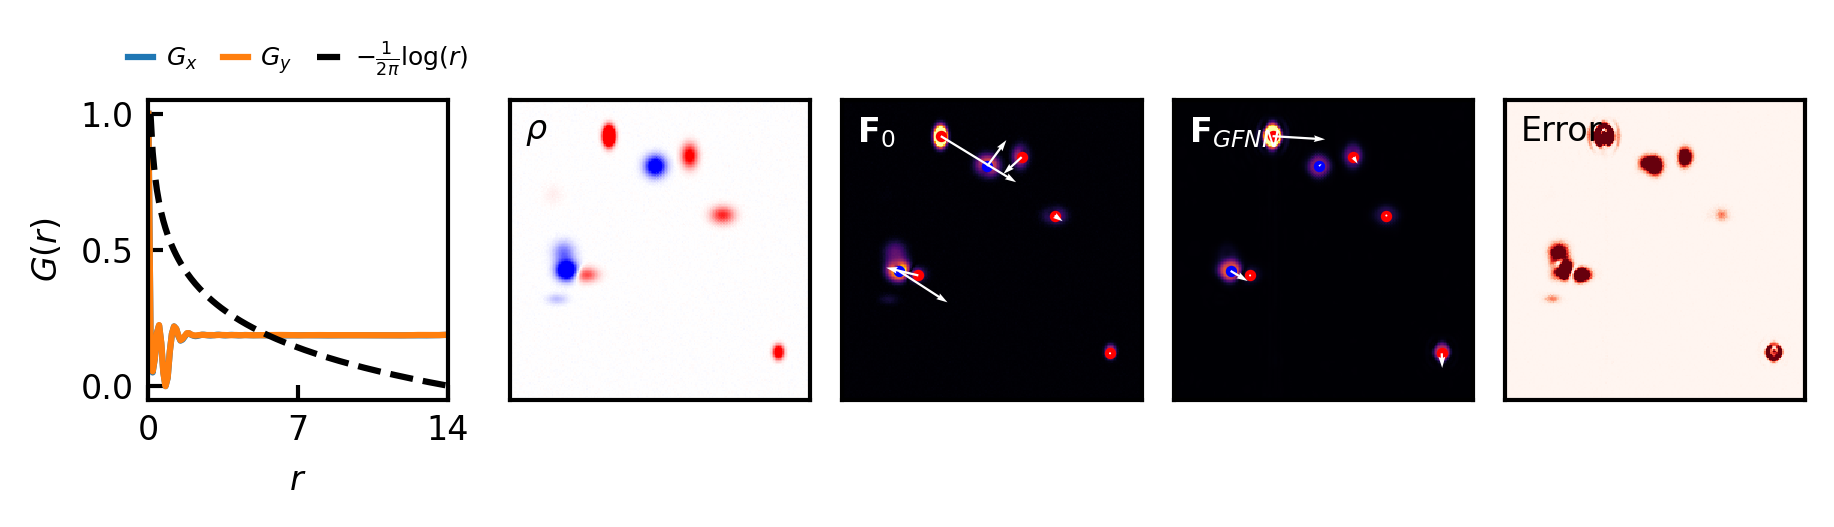

In [200]:
batch = next(iter(val_loader))
with torch.no_grad():
    idx = 0
    x = batch['f']
    y0 = batch['v'][idx].numpy()
    y = model1(x)[idx].numpy()
    x = x[idx].numpy()
    
    kernels = fft.irfft2(model1.get_kernels(), s=x.shape[-2:])
    kernels = fft.ifftshift(kernels, dim=(-2, -1)).numpy()
    dx = dataset.x[0, 1, 1] - dataset.x[0, 0, 0]
    kernels = kernels * 2 * np.pi**2 / dx.numpy()
            
fig, ax = plt.subplots(1, 5, dpi=300, figsize=(6, 2), constrained_layout=True)
ax[1].pcolormesh(dataset.x[0], dataset.x[1], x, cmap='bwr', vmin=-vmax, vmax=vmax)
plot_force(ax[2], dataset.x, x, y0, s=3, cmap='inferno')
plot_force(ax[3], dataset.x, x, y, s=3, cmap='inferno')
plot_residual(ax[4], y0, y)

rgrid = np.linalg.norm(dataset.x, axis=0)
rmax = np.max(rgrid)
r = np.arange(0, rmax, dx.item())
eps = 5e-1
kr = np.empty([kernels.shape[0], len(r)])
for j in range(len(r)):
    radii = kernels[..., np.abs(rgrid - r[j]) < eps]
    kr[:, j] = np.average(radii, axis=-1)

G_r = (kr - np.min(kr, axis=1, keepdims=True)) / np.ptp(kr, axis=1, keepdims=True)
ax[0].plot(r, G_r[0], label=r'$G_{x}$')
ax[0].plot(r, G_r[1], label=r'$G_{y}$')

G_r = -np.log(r) / (2 * np.pi)
G_r = (G_r - np.min(G_r[r > 0])) / np.ptp(G_r[r > 0])
ax[0].plot(r, G_r, label=r'$-\frac{1}{2\pi} \log(r)$', color='black', linestyle='--')

ax[0].set(xlim=[0, int(rmax)], xticks=[0, rmax//2, int(rmax)], xlabel='$r$', ylabel='$G(r)$')
ax[0].legend(framealpha=0, ncol=3, 
             fontsize=6,
             bbox_to_anchor=[0.5, 1], loc='lower center', 
             columnspacing=1, handletextpad=0.5, handlelength=1)
ax[0].set_aspect(np.ptp(ax[0].get_xlim()) / np.ptp(ax[0].get_ylim()))

for a in ax.flatten()[1:]:
    a.set(xticks=[], yticks=[], aspect='equal')

x, y = 0.05, 0.95
fig.text(x, y, '$\\rho$', 
         ha='left', va='top',
         color='black', transform=ax[1].transAxes)
fig.text(x, y, '$\\mathbf{F}_{0}$', 
         ha='left', va='top',
         color='white', transform=ax[2].transAxes)
fig.text(x, y, '$\\mathbf{F}_{GFNN}$', 
         ha='left', va='top',
         color='white', transform=ax[3].transAxes)
fig.text(x, y, 'Error', 
         ha='left', va='top',
         color='black', transform=ax[4].transAxes)

# Clebsch decomposition method

The flaw with the previous example is that we did not allow for full generality in transforming a scalar $\rho$ to a vector $\mathbf{F}$. A generic vector field can be decomposed in a Clebsch representation into three scalar fields as $\mathbf{v} = \nabla \phi + \xi \nabla \chi$.

In order to obtain $\mathbf{F}$ from $\phi$, we assume $\mathbf{F} = \nabla \phi + \xi \nabla \chi$, where each Clebsch field satisfies some linear differential relationship with $\rho$. This can be tested with a Green's function neural network which explicitly computes each Clebsch field, then combines them to estimate $\mathbf{F}$. 

In [201]:
class ClebschGFNN(GFNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.conv_in = nn.Sequential(
            ConvBlock(1, 64, kernel_size=3),
            nn.Conv2d(64, 3, kernel_size=1)
        )
        
        # Since the RHS of each PDE is a scalar, we need three scalar Green's functions
        self.kernels = torch.nn.Parameter(
            torch.empty((3, self.size, self.size//2+1), dtype=torch.cfloat),
            requires_grad=True)
        
        q = fft.fftfreq(self.size)
        q = torch.stack(torch.meshgrid(q, q, indexing='ij'), dim=0)
        q = q[:, :self.kernels.shape[-2], :self.kernels.shape[-1]]
        self.q = torch.nn.Parameter(q, requires_grad=False)
        
        torch.nn.init.xavier_uniform_(self.kernels)
            
    def forward(self, x):
        b = x.shape[0]
        h, w = x.shape[-2:]
        x = x.reshape([b, -1, h, w])
        x = self.conv_in(x)
        xq = torch.fft.rfft2(x, s=[h, w])
        
        xq = xq * self.get_kernels()
        
        grad_phi = torch.fft.irfft2(mtwopii * self.q * xq[:, 0:1], s=[h,w])
        psi = torch.fft.irfft2(xq[:, 1:2], s=[h, w])
        grad_chi = torch.fft.irfft2(mtwopii * self.q * xq[:, 2:3], s=[h,w])
        
        x = grad_phi + psi * grad_chi
        
        return x

model2 = ClebschGFNN()
trainer = pl.Trainer(gpus=1, max_epochs=50, checkpoint_callback=False)
trainer.fit(model2, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | conv_in | Sequential | 33.9 K
---------------------------------------
94.8 K    Trainable params
40.6 K    Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

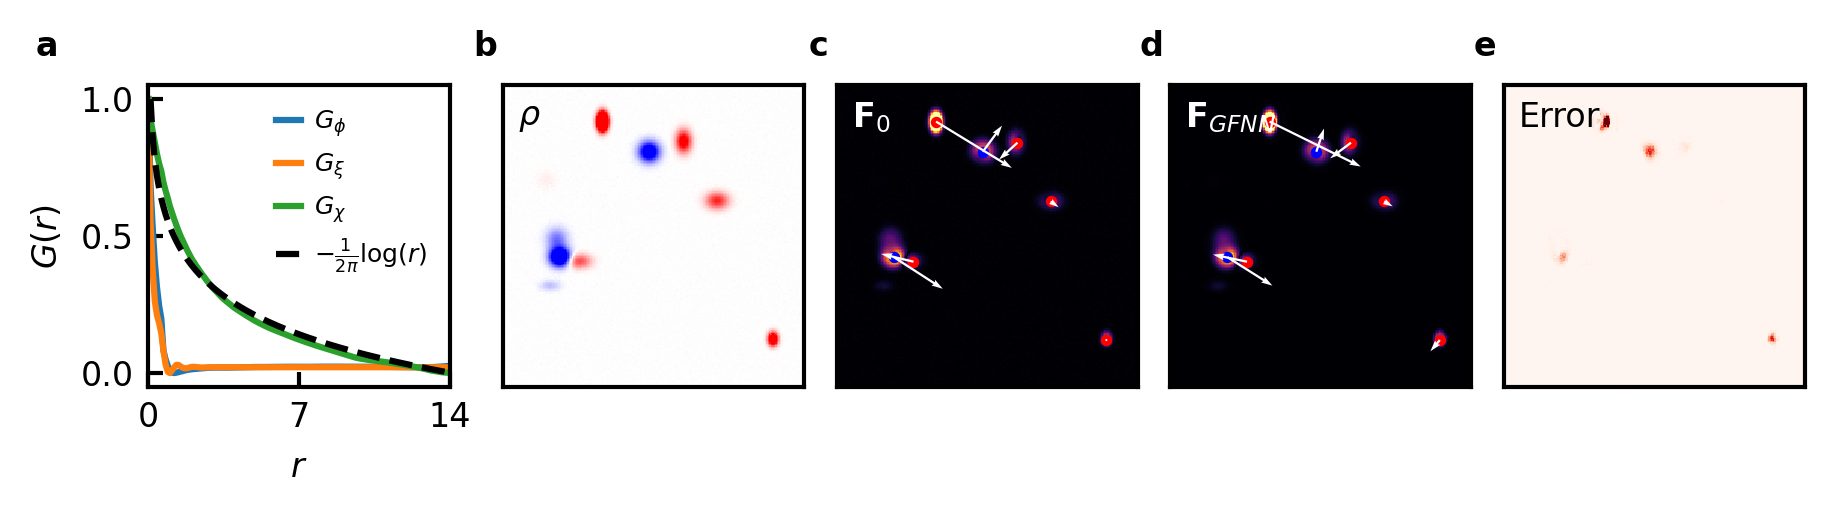

In [247]:
batch = next(iter(val_loader))
with torch.no_grad():
    idx = 0
    x = batch['f']
    y0 = batch['v'][idx].numpy()
    y = model2(x)[idx].numpy()
    x = x[idx].numpy()
    
    kernels = fft.irfft2(model2.get_kernels(), s=x.shape[-2:])
    kernels = fft.ifftshift(kernels, dim=(-2, -1)).numpy()
    dx = dataset.x[0, 1, 1] - dataset.x[0, 0, 0]
    kernels = kernels * 2 * np.pi**2 / dx.numpy()
            
fig, ax = plt.subplots(1, 5, dpi=300, figsize=(6, 1.5), constrained_layout=True)
ax[1].pcolormesh(dataset.x[0], dataset.x[1], x, cmap='bwr', vmin=-vmax, vmax=vmax)
plot_force(ax[2], dataset.x, x, y0, s=3, cmap='inferno')
plot_force(ax[3], dataset.x, x, y, s=3, cmap='inferno')
plot_residual(ax[4], y0, y)

rgrid = np.linalg.norm(dataset.x, axis=0)
rmax = np.max(rgrid)
r = np.arange(0, rmax, dx.item())
eps = 5e-1
kr = np.empty([kernels.shape[0], len(r)])
for j in range(len(r)):
    radii = kernels[..., np.abs(rgrid - r[j]) < eps]
    kr[:, j] = np.average(radii, axis=-1)

G_r = (kr - np.min(kr, axis=1, keepdims=True)) / np.ptp(kr, axis=1, keepdims=True)
ax[0].plot(r, G_r[0], label=r'$G_{\phi}$')
ax[0].plot(r, G_r[1], label=r'$G_{\xi}$')
ax[0].plot(r, G_r[2], label=r'$G_{\chi}$')

G_r = -np.log(r) / (2 * np.pi)
G_r = (G_r - np.min(G_r[r > 0])) / np.ptp(G_r[r > 0])
ax[0].plot(r, G_r, label=r'$-\frac{1}{2\pi} \log(r)$', color='black', linestyle='--')

ax[0].set(xlim=[0, int(rmax)], xticks=[0, rmax//2, int(rmax)], xlabel='$r$', ylabel='$G(r)$')
ax[0].legend(framealpha=0, fontsize=6,
             #bbox_to_anchor=[0.5, 1], loc='lower center', 
             columnspacing=1, handletextpad=0.5, handlelength=1)
ax[0].set_aspect(np.ptp(ax[0].get_xlim()) / np.ptp(ax[0].get_ylim()))

for a in ax.flatten()[1:]:
    a.set(xticks=[], yticks=[], aspect='equal')

x, y = 0.05, 0.95
fig.text(x, y, '$\\rho$', 
         ha='left', va='top',
         color='black', transform=ax[1].transAxes)
fig.text(x, y, '$\\mathbf{F}_{0}$', 
         ha='left', va='top',
         color='white', transform=ax[2].transAxes)
fig.text(x, y, '$\\mathbf{F}_{GFNN}$', 
         ha='left', va='top',
         color='white', transform=ax[3].transAxes)
fig.text(x, y, 'Error', 
         ha='left', va='top',
         color='black', transform=ax[4].transAxes)

fig.text(0.01, 1, 'a', ha='left', va='center', fontweight='bold')
x0 = 0.26
dx = 0.185
fig.text(x0+0*dx, 1, 'b', ha='center', va='center', fontweight='bold')
fig.text(x0+1*dx, 1, 'c', ha='center', va='center', fontweight='bold')
fig.text(x0+2*dx, 1, 'd', ha='center', va='center', fontweight='bold')
fig.text(x0+3*dx, 1, 'e', ha='center', va='center', fontweight='bold')

plt.savefig('Figures/Coulomb_Clebsch.png', bbox_inches='tight')